# Final Project  
# 95-791 Data Mining
# Name: Wendy Zhang, Yanyu Chen, Peijun Chen

## Project Descripton
We have been working with life expectancy and related factors datasets for 193 countries from year 2000 to 2015. Our main dataset is from Kaggle called life expectancy (WHO) and it has multiple variables that might affecting life expectancy such as schooling and alcohol consumption. However, after we dived deeper into the datasets, we found it has some inconsistent data in several columns. In order to solve that problem, we decided to extract columns that don’t have inconsistent data and replaced the problematic columns with data we found from OurWorldInData. Therefore, we have 4 datasets including the one extracting data from Kaggle. The rest 3 datasets include immunization dataset (Hepatitis B, DPT, Measles), nutrition dataset (undernourishment, obesity) and socioeconomic dataset (mortality rate, homicide rate, GDP). Because every dataset has country name and year columns, we merged them together based on those columns to produce the final dataset we used to build models. 

We hope to use three different models to answer the following questions: 

1.	What are the predicting variables actually affecting life expectancy? Are these variables positively/negatively correlated with life expectancy? What is the best model to predict the life expectancy?


2.	Grouping the countries into countries with higher mortality rate (>=2.5), countries with medium mortality rate (between 1.0 and 2.5) and countries with lower mortality rate (<1.0), what factors are most important in leading a country with a lower mortality rate? Does increasing healthcare expenditure and having universal health coverage significantly help a country to improve its mortality rate?


3.	Using unsupervised learning to cluster the countries, how will the countries be clustered together? How well are they clustered? What factors do they have in common? Is there a same country in different years clustered to different groups? If so, what might be the reasons behind? 



## Installing and loading packages

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import plotly.express as px
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, cross_val_score
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn import neighbors
from sklearn.metrics import r2_score 
from sklearn.datasets import load_boston
from sklearn.datasets import load_wine
import time
from sklearn import tree
from IPython.display import Image
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, BaggingRegressor 
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, cross_val_score
from dtreeviz.trees import dtreeviz
import graphviz
import statsmodels.formula.api as smf

%matplotlib inline
plt.style.use('seaborn-white')


## Data Cleaning 

In [2]:
# We have four dataset and will merge them together based on country name and year
socio_econ = pd.read_csv("socioeconomic.csv")
vaccination = pd.read_csv("Vaccination.csv")
merge_1 = pd.merge(socio_econ, vaccination)
merge_1.to_csv('merge1.csv')


Nutrition = pd.read_csv("Nutrition.csv")
Additional_features = pd.merge(merge_1, Nutrition)
Additional_features.to_csv('Additional_features.csv')


Kaggle = pd.read_csv("ExtractedKaggle.csv")
final_data = pd.merge(Kaggle,Additional_features)
final_data.to_csv('final_data.csv')

In [3]:
# Load the final merged dataset into a dataframe called LE and print the first 5 rows
LE= pd.read_csv("final_data.csv") 
LE= LE.drop(columns = ['Unnamed: 0'])
LE.head()
                            

,Country,Year,Status,Alcohol,HIV/AIDS,Schooling,Code,Mortality rate,GDP,Homicide,Health expenditure,Universal_healthcare,Hepatitis B,DPT,Measles,Life expectancy,Obesity,undernourishment
0,Afghanistan,2014,Developing,0.01,0.1,10.0,AFG,7.36,2102.384604,1.416649,8.182274,0,62.0,62.0,60.0,62.966,4.9,26.4
1,Afghanistan,2013,Developing,0.01,0.1,9.9,AFG,7.68,2116.465258,1.436770,8.134866,0,64.0,64.0,57.0,62.525,4.7,26.5
2,Afghanistan,2012,Developing,0.01,0.1,9.8,AFG,8.03,2075.491614,1.396701,8.518913,0,67.0,67.0,59.0,62.054,4.4,27.2
3,Afghanistan,2011,Developing,0.01,0.1,9.5,AFG,8.39,1904.559926,1.394576,7.871992,0,68.0,68.0,64.0,61.553,4.2,25.0
4,Afghanistan,2010,Developing,0.01,0.1,9.2,AFG,8.76,1957.029070,1.393585,9.197723,0,66.0,66.0,62.0,61.028,4.0,24.1


In [4]:
# Check if there are any missing values and if there are, how many are they.
LE.info()
print(LE.isnull().sum(axis=0))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1790 entries, 0 to 1789
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Country               1790 non-null   object 
 1   Year                  1790 non-null   int64  
 2   Status                1790 non-null   object 
 3   Alcohol               1789 non-null   float64
 4   HIV/AIDS              1790 non-null   float64
 5   Schooling             1762 non-null   float64
 6   Code                  1790 non-null   object 
 7   Mortality rate        1790 non-null   float64
 8   GDP                   1790 non-null   float64
 9   Homicide              1790 non-null   float64
 10  Health expenditure    1790 non-null   float64
 11  Universal_healthcare  1790 non-null   int64  
 12  Hepatitis B           1647 non-null   float64
 13  DPT                   1785 non-null   float64
 14  Measles               1785 non-null   float64
 15  Life expectancy      

In [5]:
#We have 143 missing value for Hepatitis B, comparing to the whole dataset
# it is not that significant and so we decide to drop the missing value to make sure that our data is consistent
LE = LE.dropna()
LE.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1633 entries, 0 to 1787
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Country               1633 non-null   object 
 1   Year                  1633 non-null   int64  
 2   Status                1633 non-null   object 
 3   Alcohol               1633 non-null   float64
 4   HIV/AIDS              1633 non-null   float64
 5   Schooling             1633 non-null   float64
 6   Code                  1633 non-null   object 
 7   Mortality rate        1633 non-null   float64
 8   GDP                   1633 non-null   float64
 9   Homicide              1633 non-null   float64
 10  Health expenditure    1633 non-null   float64
 11  Universal_healthcare  1633 non-null   int64  
 12  Hepatitis B           1633 non-null   float64
 13  DPT                   1633 non-null   float64
 14  Measles               1633 non-null   float64
 15  Life expectancy      

In [6]:
#We need to turn status into a binary columns so 1 means developed and 0 means developing
LE = pd.get_dummies(LE, columns = ["Status"])
LE = LE.drop(columns = ["Status_Developing"])


### Because we want to build a model to predict life expectancy which based on health factors such as immunization and healthcare coverage, socioeconomic factors such as GDP and homicide rate and lifestyle such as alcohol consumption and  etc. But we don't really need the country name column, country code column, year column. These three columns won't play vital role in predicting life expectancy. So, we decide to drop these three columns.

In [7]:
LE = LE.drop(columns = ["Country", "Code", "Year"])
LE.head()

,Alcohol,HIV/AIDS,Schooling,Mortality rate,GDP,Homicide,Health expenditure,Universal_healthcare,Hepatitis B,DPT,Measles,Life expectancy,Obesity,undernourishment,Status_Developed
0,0.01,0.1,10.0,7.36,2102.384604,1.416649,8.182274,0,62.0,62.0,60.0,62.966,4.9,26.4,0
1,0.01,0.1,9.9,7.68,2116.465258,1.436770,8.134866,0,64.0,64.0,57.0,62.525,4.7,26.5,0
2,0.01,0.1,9.8,8.03,2075.491614,1.396701,8.518913,0,67.0,67.0,59.0,62.054,4.4,27.2,0
3,0.01,0.1,9.5,8.39,1904.559926,1.394576,7.871992,0,68.0,68.0,64.0,61.553,4.2,25.0,0
4,0.01,0.1,9.2,8.76,1957.029070,1.393585,9.197723,0,66.0,66.0,62.0,61.028,4.0,24.1,0


### We want to make sure the names of the columns are consistent. So we replace the spaces with or '_' and make all names capitalized 


In [8]:
LE.columns = LE.columns.str.replace(' ', '_')
LE.columns = LE.columns.str.upper()

In [9]:
LE.head()

,ALCOHOL,HIV/AIDS,SCHOOLING,MORTALITY_RATE,GDP,HOMICIDE,HEALTH_EXPENDITURE,UNIVERSAL_HEALTHCARE,HEPATITIS_B,DPT,MEASLES,LIFE_EXPECTANCY,OBESITY,UNDERNOURISHMENT,STATUS_DEVELOPED
0,0.01,0.1,10.0,7.36,2102.384604,1.416649,8.182274,0,62.0,62.0,60.0,62.966,4.9,26.4,0
1,0.01,0.1,9.9,7.68,2116.465258,1.436770,8.134866,0,64.0,64.0,57.0,62.525,4.7,26.5,0
2,0.01,0.1,9.8,8.03,2075.491614,1.396701,8.518913,0,67.0,67.0,59.0,62.054,4.4,27.2,0
3,0.01,0.1,9.5,8.39,1904.559926,1.394576,7.871992,0,68.0,68.0,64.0,61.553,4.2,25.0,0
4,0.01,0.1,9.2,8.76,1957.029070,1.393585,9.197723,0,66.0,66.0,62.0,61.028,4.0,24.1,0


**We now need to divide our dataset into `X` and `y`.**

In [10]:
X = LE.drop(columns = ['LIFE_EXPECTANCY'])
y = LE['LIFE_EXPECTANCY']

## Plots (correlation matrix, boxplots, histogram)

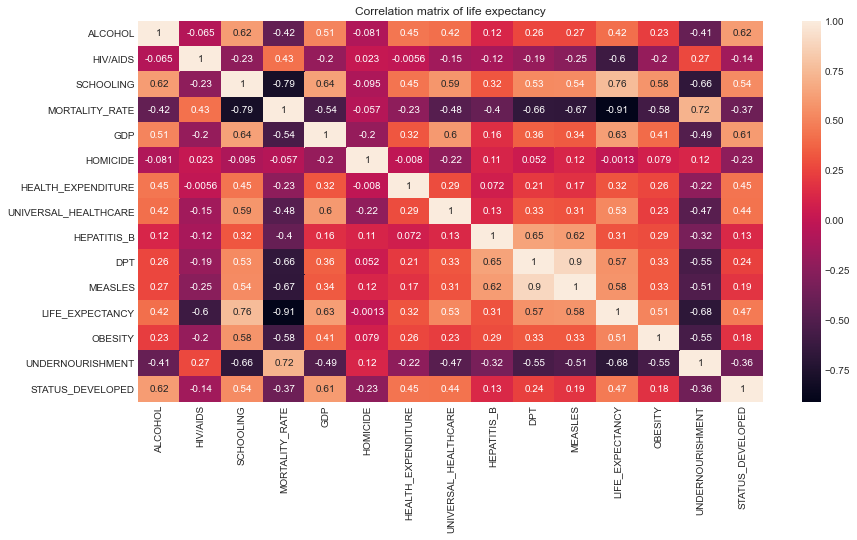

In [11]:
# Correlation matrix 
correlation_matrix = LE.corr()
plt.figure(figsize = (14,7))
sns.heatmap(correlation_matrix, annot = True)
plt.title("Correlation matrix of life expectancy")
plt.show()

From correlation matrix, we have many interesting findings. The immunizations measles, DPT are highly correlated to each other (0.9). They are essentially collinear variables. This makes logical sense, as the they are all vaccines that newborn should be injected. Alcohol and country status (developing/developed) are correlated (0.62) so we might speculate that people who are from developed country tend to drink more alcohol. Schooling and GDP per capita are correlated as well (0.64). So we guess people who receive more years of education will make more money. 

### Histogram to view the distribution of life expectancy

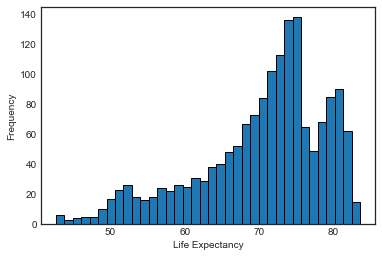

In [12]:
# Histogram could gives us the sense of the distribution of target variable
plt.hist(y, edgecolor ='black',
                bins = int(180/5))
plt.xlabel('Life Expectancy')
plt.ylabel('Frequency')
plt.show()

The disparity of distribution of life expectancy among different countries is significant, the majority of countries has the life expectancy of 65-75 years, and fewer have over 80 years or less than 60 years. The large disparity could make the standard error lower and make the result more credible.  

## Prediction

1. What are the predicting variables actually affecting life expectancy?Is it positive/negative?   What is the best model to predict the life expectancy? 

#### What factors are correlated with life expectancy? Is it positive/negative? 
USE OLS Model to Briefly Answer the first question

In [13]:
# get a copy for future need
# get a new dataset to deal with
LE_trial = LE.copy()

# Rename the column name to get it done by ols model
LE_trial = LE_trial.rename(columns={'HIV/AIDS': 'HIV_AIDS'})

reg_multi_weekdays = smf.ols('LIFE_EXPECTANCY ~ ALCOHOL + HIV_AIDS + SCHOOLING + MORTALITY_RATE + GDP + HOMICIDE + HEALTH_EXPENDITURE + UNIVERSAL_HEALTHCARE + HEPATITIS_B + MEASLES+ OBESITY + UNDERNOURISHMENT + STATUS_DEVELOPED +DPT'
, LE_trial).fit()
reg_multi_weekdays.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        LIFE_EXPECTANCY   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.924
Method:                 Least Squares   F-statistic:                     1411.
Date:                Fri, 10 Dec 2021   Prob (F-statistic):               0.00
Time:                        11:27:46   Log-Likelihood:                -3727.4
No. Observations:                1633   AIC:                             7485.
Df Residuals:                    1618   BIC:                             7566.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               74.2274      0.861     86.223      0.000      72.539      75.916
ALCOHOL                 -0.1424      0.022     -6.575      0.000      -0.185      -0.100
HIV_AIDS                -0.5482      0.016    -34.143      0.000      -0.580      -0.517
SCHOOLING                0.1439      0.046      3.108      0.002       0.053       0.235
MORTALITY_RATE          -1.4431      0.035    -41.088      0.000      -1.512      -1.374
GDP                   6.613e-05   5.05e-06     13.103      0.000    5.62e-05     7.6e-05
HOMICIDE                 0.1238      0.032      3.909      0.000       0.062       0.186
HEALTH_EXPENDITURE       0.3679      0.031     11.809      0.000       0.307       0.429
UNIVERSAL_HEALTHCARE     0.7058      0.170      4.155      0.000       0.373       1.039
HEPATITIS_B             -0.0149      0.004     -3.433      0.001      -0.023      -0.006
MEASLES                 -0.0068      0.011     -0.625      0.532      -0.028       0.015
OBESITY                 -0.0500      0.010     -4.995      0.000      -0.070      -0.030
UNDERNOURISHMENT        -0.0382      0.010     -3.998      0.000      -0.057      -0.019
STATUS_DEVELOPED         1.2483      0.233      5.363      0.000       0.792       1.705
DPT                     -0.0009      0.012     -0.079      0.937      -0.024       0.022
==============================================================================
Omnibus:                      109.734   Durbin-Watson:                   0.193
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              151.979
Skew:                          -0.572   Prob(JB):                     9.96e-34
Kurtosis:                       3.962   Cond. No.                     3.71e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.71e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

From the OLS regression result, we can see that MORTALITY_RATE, HIV_AIDS, GDP, HEALTH_EXPENDITURE, ALCOHOL are highly associated with the life expectancy. Among these variables, mortality rate, HIV/AIDS, obesity has a negative correlation to the life expectancy. And GDP, Health Expenditures, schooling has a positive correlation to the life expectancy. Out of expectation, homocide has a positive correlation with life expectancy and HEPATITIS_B is negatively correlated with the life expectancy. DPT and MEASLES (two kinds of vaccination rate) are not significantly correlated with the life expectancy. 

###  Split the dataset to train different models

In [14]:
# Split the dataset and using 0.25 as the test dataset

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

### Use feature selector and CV to find what features are actually contributing to prediction

In [15]:
# Get the CV error for each feature selection
CV_scores = []
model= LinearRegression()
feature_names= X_train.columns

# For loop for n-1 times to get the feature selection
for feats in range(1, np.shape(X)[1]):
    print("Num Features:",feats)
    sfs = SequentialFeatureSelector(model, 
                                    n_features_to_select = feats, 
                                    direction="forward",
                                    scoring='neg_mean_squared_error',
                                    cv=10) 
    sfs = sfs.fit(X_train,y_train)
    print("\tFeatures selected:", str(feature_names[sfs.get_support()]))
    X_subset = sfs.transform(X_train)
    CV_error = np.mean(cross_val_score(model, X_subset, y_train, cv=10, scoring='neg_mean_squared_error'))
    CV_scores.append(CV_error)
    print("\tCV_Error: %10.3f"%CV_error)

    model= LinearRegression()

Num Features: 1
	Features selected: Index(['MORTALITY_RATE'], dtype='object')
	CV_Error:    -13.353
Num Features: 2
	Features selected: Index(['HIV/AIDS', 'MORTALITY_RATE'], dtype='object')
	CV_Error:     -9.136
Num Features: 3
	Features selected: Index(['HIV/AIDS', 'MORTALITY_RATE', 'GDP'], dtype='object')
	CV_Error:     -7.106
Num Features: 4
	Features selected: Index(['HIV/AIDS', 'MORTALITY_RATE', 'GDP', 'HEALTH_EXPENDITURE'], dtype='object')
	CV_Error:     -6.253
Num Features: 5
	Features selected: Index(['HIV/AIDS', 'MORTALITY_RATE', 'GDP', 'HEALTH_EXPENDITURE', 'OBESITY'], dtype='object')
	CV_Error:     -6.152
Num Features: 6
	Features selected: Index(['HIV/AIDS', 'MORTALITY_RATE', 'GDP', 'HEALTH_EXPENDITURE',
       'UNIVERSAL_HEALTHCARE', 'OBESITY'],
      dtype='object')
	CV_Error:     -6.100
Num Features: 7
	Features selected: Index(['ALCOHOL', 'HIV/AIDS', 'MORTALITY_RATE', 'GDP', 'HEALTH_EXPENDITURE',
       'UNIVERSAL_HEALTHCARE', 'OBESITY'],
      dtype='object')
	CV_Error

#### There are only 13 times that the last part has done, to make sure that the last feature is being tested. The next step is a cross validation on the whole X_train, y_train model to get the total result

In [16]:
CV_error = np.mean(cross_val_score(model, X_train, y_train, cv=10, scoring='neg_mean_squared_error'))
CV_error

-5.837686680573635

#### According to the feature selection, the number of feature corresponds to the lowest CV error is 13 and the 'Measles' increased CV error so it doesn't contribute much to the predction and it should be dropped in the next step. The last cross validation result shows higher cv error, which means that adding the last feature of 'DPT' does not reduce the error. So we do not select DPT as well.

### Fit a model to dataset Training and Testing

In [17]:
# According to the CV error, ['OBESITY', 'CHILD_MORTALITY_RATE', 'GDP_PER_CAPITA', 'HEALTH_EXPENDITURE', 'HOMICIDE_RATE', 'UNDERNOURISHMENT_RATE', 'ALCOHOL', 'HIV/AIDS','SCHOOLING', 'UNIVERSAL_HEALTHCARE', 'STATUS_DEVELOPED'] are the features that we select that are important
# 'Measles'  and 'DPT' do not decrease the CV error so drop this feature

# Define the new X, y for both train, and test using new features 


X = LE.drop(columns = ['LIFE_EXPECTANCY', 'MEASLES', 'DPT'])
y = LE['LIFE_EXPECTANCY']

# Redefine the test and train data after feature selection 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)



### Model Selection - fitting different models, and choose the best model

### 1. Linear Regression

In [18]:
# fit the train data into linear regression model
lm = LinearRegression()
lm.fit(X_train,y_train)

# Get the r-squared and MSE value
print("Train R-squared: ", lm.score(X_train,y_train))
print('Train MSE: %.2f'% mean_squared_error(y_train, lm.predict(X_train)))

print("Testing R-squared: ", lm.score(X_test,y_test))
print('Test MSE: %.2f'% mean_squared_error(y_test, lm.predict(X_test)))

Train R-squared:  0.9231625935551451
Train MSE: 5.66
Testing R-squared:  0.9267609681176263
Test MSE: 5.60


##### Linear regression model have a good fit with the original data as the MSE is quite small (Train MSE is only 5.66, and test MSE is only 5.60) and R-square is greater than 0.92 for both training data and testing data

###  2. Polynomial model

In [19]:
# Introduce the model
lm_poly = LinearRegression()


# Test 10 degrees of polynomial model to see which degree fits the best
for i in range(1,8):
    poly = PolynomialFeatures(degree=i)
    X_poly_train = poly.fit_transform(X_train)
    X_poly_test = poly.fit_transform(X_test)
    lm_poly.fit(X_poly_train, y_train)
    # print the result of Train R-squared, Train MSE, Testing R-squared, and Test MSE
    print("------------")
    print("Degree: ",i)
    print("Train R-squared: ", lm.score(X_train,y_train))
    print('Train MSE: {}'.format(cross_val_score(lm_poly, X_poly_train, y_train, cv = 10, scoring="neg_mean_squared_error").mean()))
    print("Testing R-squared: ", lm.score(X_test,y_test))
    print('Test MSE: {}'.format(cross_val_score(lm_poly, X_poly_test, y_test, cv = 10, scoring="neg_mean_squared_error").mean()))

------------
Degree:  1
Train R-squared:  0.9231625935551451
Train MSE: -5.816556821811478
Testing R-squared:  0.9267609681176263
Test MSE: -5.761978966630812
------------
Degree:  2
Train R-squared:  0.9231625935551451
Train MSE: -2.5609726768629066
Testing R-squared:  0.9267609681176263
Test MSE: -4.2563441395521
------------
Degree:  3
Train R-squared:  0.9231625935551451
Train MSE: -6.845658939446148
Testing R-squared:  0.9267609681176263
Test MSE: -909.2350154181847
------------
Degree:  4
Train R-squared:  0.9231625935551451
Train MSE: -6.705831355346722
Testing R-squared:  0.9267609681176263
Test MSE: -958.8612574058355
------------
Degree:  5
Train R-squared:  0.9231625935551451
Train MSE: -42.01405493718231
Testing R-squared:  0.9267609681176263
Test MSE: -15465.53068774231
------------
Degree:  6
Train R-squared:  0.9231625935551451
Train MSE: -560.7122599309525
Testing R-squared:  0.9267609681176263
Test MSE: -66611.02951759913
------------
Degree:  7
Train R-squared:  0.923

The linear regression (degree = 2) has the lowest test MSE comparing to other degress. Beyond degree 3 the models are definitely overfited and the MSE for the test dataset increases significantly.

### 3.  Regularized Regression: Ridge

In [20]:
# Define the model_ridge
model_ridge = Ridge(normalize=True)
# Get empty list first
errors= []
coefficents_ridge = []

alphas = np.logspace(-5, 5, 300)

# Find the alphas and minimum error for Ridge model
for a in alphas:
    model_ridge.set_params(alpha=a)
    # fit the ridge model with the train data
    model_ridge.fit(X_train, y_train)
    # Get cv error
    CV_error = np.mean(cross_val_score(model_ridge, X_train, y_train, cv=10, scoring='neg_mean_squared_error'))
    coefficents_ridge.append(model_ridge.coef_)
    errors.append(CV_error)

# Get the positive value of errors
error = np.abs(errors)
print("Min error: ", np.min(error))
ridge_minError = np.min(error)
index_minerr = (np.where(error == np.min(error))[0])
Ridge_best_alpha = alphas[index_minerr]
print("Best alpha: ", Ridge_best_alpha)

Min error:  5.816319264134227
Best alpha:  [0.0014925]


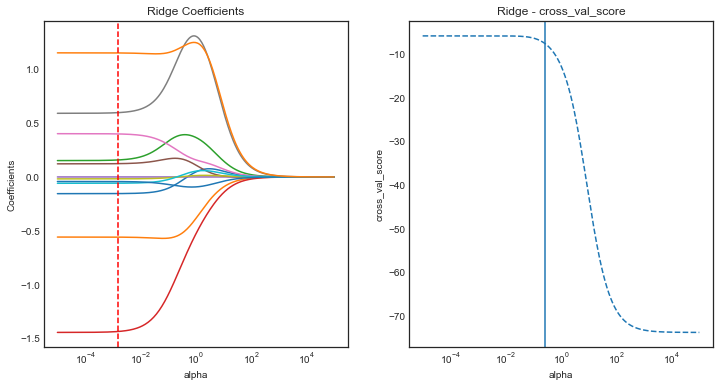

In [21]:
# Draw the graphs for Ridge coefficients and Cross Validation Value

plt.figure(figsize=(12, 6))
np_ridge = np.array(coefficents_ridge)

plt.subplot(121)
ax = plt.gca()
ax.plot(alphas, np_ridge)
# Get the line where get the best alpha
plt.axvline(x=alphas[index_minerr], color='r', linestyle='--')
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('Coefficients')
plt.title('Ridge Coefficients')
plt.axis('tight')

plt.subplot(122)
ax = plt.gca()
plt.axvline(x=0.2644260274430429)
ax.plot(alphas, errors,linestyle="--", label="Test")
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('cross_val_score')
plt.title('Ridge - cross_val_score')
plt.axis('tight')

plt.show()

Best alpha is 0.0014925, the min error is 5.816

### 4. Regularized Regression: Lasso

In [22]:
model_lasso = Lasso(normalize=True)
# Get empty list first
errors= []
coefficents_lasso = []

alphas = np.logspace(-5, 5, 300)
# Find the alphas and minimum error for Lasso model
for a in alphas:
    model_lasso.set_params(alpha=a)
    model_lasso.fit(X_train, y_train)
    # fit the ridge model with the train data
    CV_error = np.mean(cross_val_score(model_lasso, X_train, y_train, cv=10, scoring='neg_mean_squared_error'))
    coefficents_lasso.append(model_lasso.coef_)
    errors.append(CV_error)
error = np.abs(errors)
# Print relevant value
print("Min error: ", np.min(error))
lasso_minerr = np.min(error)
index_minerr = (np.where(error == np.min(error))[0])+1
Lasso_best_alpha = alphas[index_minerr]
print("Best alpha: ", Lasso_best_alpha)

Min error:  5.816525049920771
Best alpha:  [3.9995091e-05]


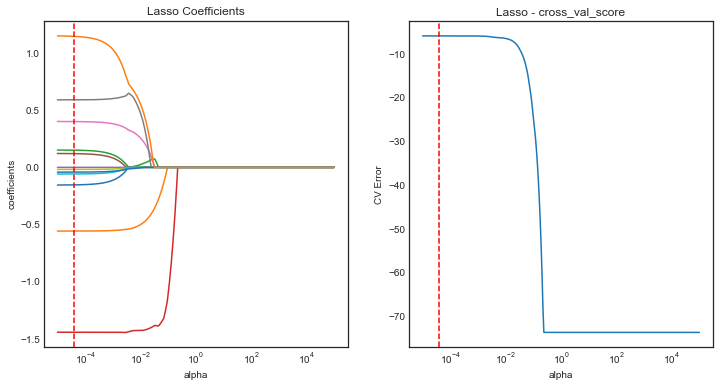

In [23]:
# Draw the graphs for Lasso coefficients and Cross Validation Value

plt.figure(figsize=(12, 6))
plt.subplot(121)
ax = plt.gca()

# Plot the graph that with the best alphas
ax.plot(alphas, coefficents_lasso)
plt.axvline(x=alphas[index_minerr], color='r', linestyle='--')
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('coefficients')
plt.title('Lasso Coefficients')
plt.axis('tight')

plt.subplot(122)
ax = plt.gca()
ax.plot(alphas, errors)
plt.axvline(x=alphas[index_minerr], color='r', linestyle='--')
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('CV Error')
plt.title('Lasso - cross_val_score')
plt.axis('tight')

plt.show()

The alpha for Lasso model is 3.9995091e-05, the min error is 5.816.

### Test the best model between Linear Regression, Polynomial, Lasso, Ridge to predict the life expectancy

##### Having discussed Linear Regression and Polynomial Regression model, degree = 2 of polynomial model performs the best, so using that model to compare with Lasso and Ridge

In [24]:
# Compare the Linear regression model, ridge, lasso for MSE in the test data to validate the result

# Get the MSE for linear regression model when degree is 2(as discussed above) because 2 degree has the lowest cv error
lm_poly = LinearRegression()
poly = PolynomialFeatures(degree=2)
X_poly_train = poly.fit_transform(X_train)
X_poly_test = poly.fit_transform(X_test)
lm_poly.fit(X_poly_train, y_train)
print('The Test MSE for Linear Regression: %.11f'% cross_val_score(lm_poly, X_poly_train, y_train, cv = 10, scoring="neg_mean_squared_error").mean())


# See the error of Ridge when predicting testing data when using the appropriate alpha that I calculate above
Test_Ridge = Ridge(alpha=Ridge_best_alpha, normalize=True)
Test_Ridge.fit(X_train,y_train)
y_pred = Test_Ridge.predict(X_test)
Test_Ridge_MSE = mean_squared_error(y_test, y_pred)
print('The Test MSE for Ridge is ', Test_Ridge_MSE)

# See the error of Lasso when predicting testing data when using the appropriate alpha that I calculate above
Test_Lasso = Lasso(alpha=Lasso_best_alpha, normalize=True)
Test_Lasso.fit(X_train,y_train)
y_pred = Test_Lasso.predict(X_test)
Test_Lasso_MSE = mean_squared_error(y_test, y_pred)
print('The Test MSE for Lasso is ', Test_Lasso_MSE)

The Test MSE for Linear Regression: -2.56097267686
The Test MSE for Ridge is  5.591109974520911
The Test MSE for Lasso is  5.593537611433738


Comparing the MSE value among Linear regression, Ridge, and Lasso, the MSE for Linear Regression (degree = 2) is the lowest so linear regression (degree = 2) is the best for predicting the life expectancy

### Random Forest Regressor

### Get the best number of trees

In [25]:
#Create an empty list to store cv error later 
CV = []
for trees in range(20,501,25):
    rf2 = RandomForestRegressor(n_estimators = trees, random_state=0, max_leaf_nodes=10)
    rf2.fit(X_train, y_train)
    CV_error = np.mean(cross_val_score(rf2, X_train, y_train, cv=10, scoring = "neg_mean_squared_error"))
    CV.append(CV_error)
    print("\t Number of Trees is ", trees, "CV_Error: %10.3f"%CV_error)

	 Number of Trees is  20 CV_Error:     -5.645
	 Number of Trees is  45 CV_Error:     -5.638
	 Number of Trees is  70 CV_Error:     -5.589
	 Number of Trees is  95 CV_Error:     -5.577
	 Number of Trees is  120 CV_Error:     -5.585
	 Number of Trees is  145 CV_Error:     -5.572
	 Number of Trees is  170 CV_Error:     -5.576
	 Number of Trees is  195 CV_Error:     -5.579
	 Number of Trees is  220 CV_Error:     -5.581
	 Number of Trees is  245 CV_Error:     -5.582
	 Number of Trees is  270 CV_Error:     -5.581
	 Number of Trees is  295 CV_Error:     -5.579
	 Number of Trees is  320 CV_Error:     -5.585
	 Number of Trees is  345 CV_Error:     -5.585
	 Number of Trees is  370 CV_Error:     -5.584
	 Number of Trees is  395 CV_Error:     -5.590
	 Number of Trees is  420 CV_Error:     -5.595
	 Number of Trees is  445 CV_Error:     -5.591
	 Number of Trees is  470 CV_Error:     -5.589
	 Number of Trees is  495 CV_Error:     -5.595


In [26]:
#Change negative values to positive values 
MSE_CV_scores =np.abs(CV)
min_CV= np.min(MSE_CV_scores)
#Number of trees 
best_CV = (np.where(MSE_CV_scores == min_CV)[0])*25+20
print('Best number of tree is: ', best_CV)
print("And its corresponding CV score is: ", min_CV)

Best number of tree is:  [145]
And its corresponding CV score is:  5.5718531466518595


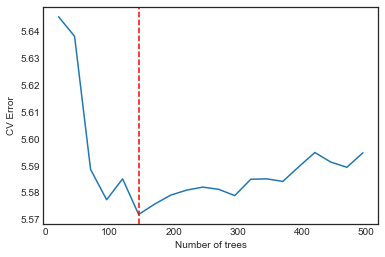

In [27]:
#Create a list for x axis
tree_num = list(range(20,501, 25))
#Plot the graph 
plt.plot(tree_num, MSE_CV_scores)
plt.xlabel("Number of trees")
plt.ylabel("CV Error")
plt.axvline(x=best_CV,linestyle='--',color="red")
plt.show()

When the tree number is 145, the cv error reaches its minimum. The cv error is 5.573 

### Use R squared to get the best tree number

In [28]:
#Create an empty list to store cv error later 
R_values = []
for trees in range(20,501,25):
    rf3 = RandomForestRegressor(n_estimators = trees, random_state=0, max_leaf_nodes=10)
    rf3.fit(X_train, y_train)
    R_value = np.mean(cross_val_score(rf3, X_train, y_train, cv=10, scoring = "r2"))
    R_values.append(R_value)   
    print("\t Number of Trees is ", trees, ", R value: %10.3f"%R_value)

	 Number of Trees is  20 , R value:      0.922
	 Number of Trees is  45 , R value:      0.922
	 Number of Trees is  70 , R value:      0.923
	 Number of Trees is  95 , R value:      0.923
	 Number of Trees is  120 , R value:      0.923
	 Number of Trees is  145 , R value:      0.923
	 Number of Trees is  170 , R value:      0.923
	 Number of Trees is  195 , R value:      0.923
	 Number of Trees is  220 , R value:      0.923
	 Number of Trees is  245 , R value:      0.923
	 Number of Trees is  270 , R value:      0.923
	 Number of Trees is  295 , R value:      0.923
	 Number of Trees is  320 , R value:      0.923
	 Number of Trees is  345 , R value:      0.923
	 Number of Trees is  370 , R value:      0.923
	 Number of Trees is  395 , R value:      0.923
	 Number of Trees is  420 , R value:      0.923
	 Number of Trees is  445 , R value:      0.923
	 Number of Trees is  470 , R value:      0.923
	 Number of Trees is  495 , R value:      0.923


In [29]:
#Change negative values to positive values 
R_scores =np.abs(R_values)
R_max= np.max(R_scores)
#Number of trees 
R_best = (np.where(R_scores == R_max)[0])*25+20
print('Best number of tree is: ', R_best)
print("And its corresponding R square value is: ", R_max)

Best number of tree is:  [145]
And its corresponding R square value is:  0.9232167248279202


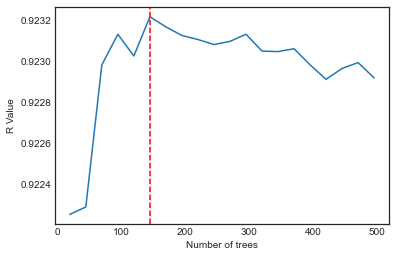

In [30]:
#Create a list for x axis
tree_num = list(range(20,501, 25))
# Plot the graph 
plt.plot(tree_num, R_scores)
plt.xlabel("Number of trees")
plt.ylabel("R Value")
plt.axvline(x=R_best,linestyle='--',color="red")
plt.show()

When the tree number equals to 145 , the R square is 0.923

### Use GridSearchCV to do the hyperparameter tuning
#### Get the best value of 'min_samples_leaf', 'max_leaf_nodes', 'max_depth'

In [31]:
# Setting the parameters
parameters = {'min_samples_leaf':[1,5], 'max_leaf_nodes':[5,10], 'max_depth':[10,40]}
regressor_new = RandomForestRegressor(random_state=0 )
clf = GridSearchCV(regressor_new, parameters)
# fit the model
clf.fit(X_train, y_train)
clf.best_params_
# get the best score

{'max_depth': 10, 'max_leaf_nodes': 10, 'min_samples_leaf': 1}

In [32]:
# Get these parameter to the new update regressor
update_regressor = RandomForestRegressor(max_depth = 10, max_leaf_nodes = 10, min_samples_leaf = 1, random_state=1, n_estimators = 145 )
update_regressor.fit(X_train, y_train)
update_pred = update_regressor.predict(X_test)
update_regressor.score(X_test, y_test)
# Get the 
update_pred = update_regressor.predict(X_test)
rfr_R2score2 = cross_val_score(update_regressor, X_train, y_train, cv=10, scoring='r2')
rfr_MSEscore2 = cross_val_score(update_regressor, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
print('R Squared Value:', rfr_R2score2.mean())
print('Negative MSE:', rfr_MSEscore2.mean())

R Squared Value: 0.9223122314880531
Negative MSE: -5.636729704156502


The adjusted tree model has the r square of 0.92, and the MSE is 5.63

### Compare the regressor model to the previous best model (linear regression, degree = 2)

In [33]:
# This step has already been done in the previous step, just to make reader know the value again

poly = PolynomialFeatures(degree=2)
X_poly_train = poly.fit_transform(X_train)
X_poly_test = poly.fit_transform(X_test)

lm_poly = LinearRegression()
lm_poly.fit(X_poly_train, y_train)
y_pred_poly = lm_poly.predict(X_poly_test)
# print the result
print("Testing R-squared of polynomial regression: ", lm.score(X_test,y_test))
print('Test MSE of polynomial regression: ', mean_squared_error(y_test, y_pred_poly))


# The MSE and R square for the model
update_regressor = RandomForestRegressor(max_depth = 10, max_leaf_nodes = 10, min_samples_leaf = 1, random_state=1, n_estimators = 145 )
update_regressor.fit(X_train, y_train)
update_pred = update_regressor.predict(X_test)
print("Testing R-squared of RandomForestRegressor: ", update_regressor.score(X_test, y_test))
print('Test MSE of RandomForestRegressor: ', mean_squared_error(y_test, update_pred))

Testing R-squared of polynomial regression:  0.9267609681176263
Test MSE of polynomial regression:  2.1175054918755563
Testing R-squared of RandomForestRegressor:  0.9239159480838881
Test MSE of RandomForestRegressor:  5.814206153595514


The polynomial degree (degree = 2) has higher R square value and lower MSE value, which proves that polynomial model performs better than random forest regressor in this model. 

### Using the new randomforest regressor to see the feature importances

Text(0.5, 0, 'Features')

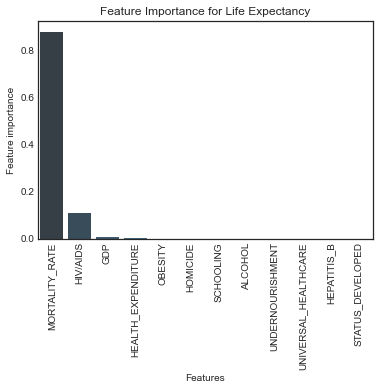

In [34]:
# get the importance data
forest_importances1 = pd.DataFrame({ 'features': X.columns, 'importances': update_regressor.feature_importances_ })
sns.barplot(x="features",y="importances" ,data=forest_importances1, 
            order=forest_importances1.sort_values('importances',ascending = False).features, palette="Blues_d")
plt.xticks(rotation=90)
plt.title("Feature Importance for Life Expectancy")
plt.ylabel("Feature importance")
plt.xlabel("Features")


The mortality rate and HIV is very important in this model, it is consistent with the previous OLS model that in the first part here. Child mortality rate directly influences on life expectancy which is not a surprise. HIV/AIDS is a fatal disease to developing countries (some countries with high HIV/AIDS rate has very low life expectancy. Other variables are showing the same result with OLS.

### Now we can answer the first question: 
What are the predicting variables actually affecting life expectancy? Is it positive/negative?   What is the best model to predict the life expectancy? 

1. What are the predicting variables? 
MORTALITY_RATE, HIV_AIDS, GDP, HEALTH_EXPENDITURE, ALCOHOL are highly associated with the life expectancy. DPT and MEASLES (two kinds of vaccination rate) are not significantly correlated with the life expectancy. 

2. Positive? Negative? 
Among these variables, mortality rate, HIV/AIDS, obesity has a negative correlation to the life expectancy. And GDP, Health Expenditures, schooling has a positive correlation to the life expectancy. Out of expectation, homocide has a positive correlation with life expectancy and HEPATITIS_B is negatively correlated with the life expectancy. 

3. The best model to predict the life expectancy
Comparing the linear regression model, the polynomial regression model, Lasso/Ridge model, and Random Forest Regressor, the Polynomial regression model (degree = 2) has the lowest MSE and the highest R value. It is the best model to predict the life expectancy



## Classification

2.	Grouping the countries into countries with higher mortality rate (>=1.81) and countries with lower mortality rate (<1.81), what factors are most important in leading a country with a lower mortality rate? Does increasing healthcare expenditure and having universal health coverage significantly help a country to improve its mortality rate?

In [35]:
# get a copy for future need

LE_trial = LE.copy()

Text(0, 0.5, 'Frequency')

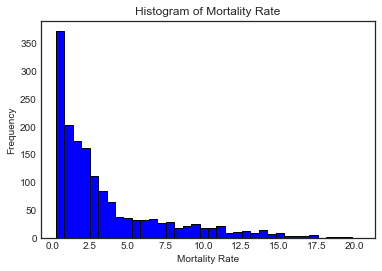

In [36]:
# Histogram of target variable (mortality rate)
plt.hist(LE_trial['MORTALITY_RATE'], color = 'blue', edgecolor ='black',
                bins = int(180/5))
# Add labels 
plt.title('Histogram of Mortality Rate')
plt.xlabel('Mortality Rate')
plt.ylabel('Frequency')

From the histogram graph, we can see that the distribution of mortality rate is right skewed. And we will group mortality rate into high (greater than 5.0) , medium (Between 2.0 and 5.0) and low (less than 2.0) categories. 

In [37]:
# Group mortality rate into low, median and high categories 
def group (x):
    if x<2.0:
        return 0
    elif x > 2.0 and x < 5.0:
        return 1
    else:
        return 2
    
LE_trial['MORTALITY_RATE'] = LE_trial['MORTALITY_RATE'].apply(lambda x:group(x))


In [38]:
#Check if grouping successful
LE_trial.head()

,ALCOHOL,HIV/AIDS,SCHOOLING,MORTALITY_RATE,GDP,HOMICIDE,HEALTH_EXPENDITURE,UNIVERSAL_HEALTHCARE,HEPATITIS_B,DPT,MEASLES,LIFE_EXPECTANCY,OBESITY,UNDERNOURISHMENT,STATUS_DEVELOPED
0,0.01,0.1,10.0,2,2102.384604,1.416649,8.182274,0,62.0,62.0,60.0,62.966,4.9,26.4,0
1,0.01,0.1,9.9,2,2116.465258,1.436770,8.134866,0,64.0,64.0,57.0,62.525,4.7,26.5,0
2,0.01,0.1,9.8,2,2075.491614,1.396701,8.518913,0,67.0,67.0,59.0,62.054,4.4,27.2,0
3,0.01,0.1,9.5,2,1904.559926,1.394576,7.871992,0,68.0,68.0,64.0,61.553,4.2,25.0,0
4,0.01,0.1,9.2,2,1957.029070,1.393585,9.197723,0,66.0,66.0,62.0,61.028,4.0,24.1,0


In [39]:
X_2 = LE_trial.drop(columns = ['LIFE_EXPECTANCY','MORTALITY_RATE'])
y_2= LE_trial['MORTALITY_RATE']

y_2

0       2
1       2
2       2
3       2
4       2
       ..
1783    1
1784    1
1785    1
1786    1
1787    1
Name: MORTALITY_RATE, Length: 1633, dtype: int64

#### split our dataset into train and test datasets

In [40]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2,y_2,
                                                    test_size=0.20,
                                                    random_state=2)
X_train_2

,ALCOHOL,HIV/AIDS,SCHOOLING,GDP,HOMICIDE,HEALTH_EXPENDITURE,UNIVERSAL_HEALTHCARE,HEPATITIS_B,DPT,MEASLES,OBESITY,UNDERNOURISHMENT,STATUS_DEVELOPED
112,2.14,0.1,11.9,14652.704250,0.516601,5.537550,0,93.0,93.0,98.0,18.2,2.5,0
1597,6.07,0.2,13.3,14450.478830,1.200170,4.119846,1,98.0,99.0,98.0,7.4,9.9,0
109,12.50,0.1,16.1,47351.334700,0.099305,10.270033,1,81.0,83.0,78.0,14.7,2.5,1
1310,6.20,0.2,12.1,8528.037930,3.617541,5.776993,0,90.0,92.0,91.0,14.2,9.2,0
1505,0.90,0.1,8.3,2122.963527,0.816688,7.834357,0,83.0,89.0,87.0,15.9,10.6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1684,9.46,0.4,14.9,13195.876840,0.752377,6.634418,1,84.0,90.0,94.0,21.4,2.5,0
1763,0.01,0.1,10.8,2975.898004,0.222937,3.920311,1,83.0,84.0,84.0,23.2,6.5,0
501,11.64,0.1,15.6,22061.271820,0.932180,4.918677,0,90.0,94.0,95.0,18.0,3.4,0
535,9.81,0.1,16.9,46825.824840,0.207988,9.011495,1,97.0,99.0,97.0,20.3,2.5,0


#### We first use randomforestregressor model to find the what factors are most important in classifying a country with a lower mortality rate.

### KNN
We are going to try a kNN (k-Nearest Naighbours) as our first classifier

In [41]:
# Use default neighbors (k = 5) to train a KNN model 
knn_default = KNeighborsClassifier().fit(X_train_2, y_train_2)
y_pred_defaultknn = knn_default.predict(X_test_2)
cm_knn_default = confusion_matrix(y_test_2,y_pred_defaultknn)

print(classification_report(y_test_2, y_pred_defaultknn, digits=3))

              precision    recall  f1-score   support

           0      0.798     0.833     0.815       156
           1      0.511     0.529     0.520        85
           2      0.829     0.733     0.778        86

    accuracy                          0.728       327
   macro avg      0.713     0.698     0.704       327
weighted avg      0.731     0.728     0.729       327



The accuracy for the default knn model is 0.728 which is not good. So we need to tune this model by finding the best k number.

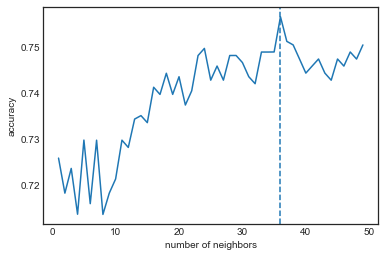

The optimal number of neighbors is:  36
Accuracy:  0.7564885496183206


In [42]:
#Creat empty list for accuracy and define range for number of neighbors 
cv_knn = []
k_range = range(1,50)
for i in range(1,50):
    knn_model = KNeighborsClassifier(n_neighbors = i)
    cv_knn.append(np.mean(cross_val_score(knn_model, X_train_2, y_train_2,
                            cv = 10)))

#Plot a graph for number of neighbors versus accuracy 
plt.plot(k_range, cv_knn)
plt.xlabel("number of neighbors")
plt.ylabel("accuracy")
#Find the optimal number of neighbors with the minimum cv errors 

best_accuracy = max(cv_knn)
cv_knn_min = cv_knn.index(best_accuracy) +1
#Draw the vertical line
plt.axvline(x=cv_knn_min, linestyle='--')
plt.show()

print("The optimal number of neighbors is: ", cv_knn_min )
print("Accuracy: ", best_accuracy)

In [43]:
# Now I have the optimal number 36 so I can apply it into KNN model and fit my KNN model
knn = KNeighborsClassifier(n_neighbors = cv_knn_min)
knn.fit(X_train_2, y_train_2)
y_pred_knn = knn.predict(X_test_2)

In [44]:
cm_knn = confusion_matrix(y_test_2,y_pred_knn)
print(classification_report(y_test_2, y_pred_knn, digits=3))

              precision    recall  f1-score   support

           0      0.820     0.878     0.848       156
           1      0.570     0.529     0.549        85
           2      0.802     0.756     0.778        86

    accuracy                          0.755       327
   macro avg      0.731     0.721     0.725       327
weighted avg      0.750     0.755     0.752       327



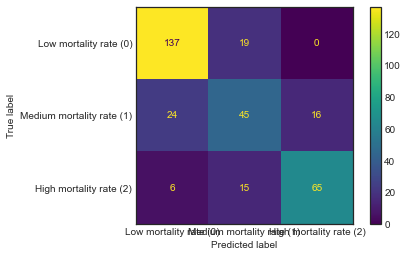

In [45]:
dissplay_cm_knn= ConfusionMatrixDisplay(confusion_matrix=cm_knn,
                                       display_labels=['Low mortality rate (0)','Medium mortality rate (1)', 'High mortality rate (2)'])
dissplay_cm_knn.plot();

Now we can see the accuracy increases from 0.728 to 0.755 after applying best k number. However, the accuracy is still not good, so let's try other models. 

### Naive Bayes
Let's try a different classifier with the same dataset.

In [46]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
y_pred_nb = nb.fit(X_train_2, y_train_2).predict(X_test_2)
cm_nb = confusion_matrix(y_test_2,y_pred_nb)
print(classification_report(y_test_2, y_pred_nb, digits=3))

              precision    recall  f1-score   support

           0      0.880     0.846     0.863       156
           1      0.648     0.694     0.670        85
           2      0.826     0.826     0.826        86

    accuracy                          0.801       327
   macro avg      0.785     0.789     0.786       327
weighted avg      0.805     0.801     0.803       327



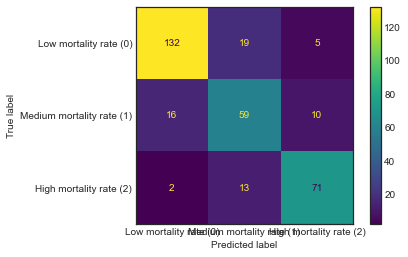

In [47]:
dissplay_cm_nb = ConfusionMatrixDisplay(confusion_matrix=cm_nb,
                                        display_labels=['Low mortality rate (0)','Medium mortality rate (1)', 'High mortality rate (2)'])
dissplay_cm_nb.plot();

NB model performs better than knn since the accuracy increases from 0.755 to 0.801. However, the accuracy is still not ideal, so let's continue to try other models.

### Logistic Regression
Let's try a third classifier with the same dataset.

In [48]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=10000)
y_pred_lr = lr.fit(X_train_2, y_train_2).predict(X_test_2)
cm_lr = confusion_matrix(y_test_2,y_pred_lr)
print(classification_report(y_test_2, y_pred_lr, digits=3))

              precision    recall  f1-score   support

           0      0.897     0.897     0.897       156
           1      0.723     0.706     0.714        85
           2      0.886     0.907     0.897        86

    accuracy                          0.850       327
   macro avg      0.836     0.837     0.836       327
weighted avg      0.849     0.850     0.850       327



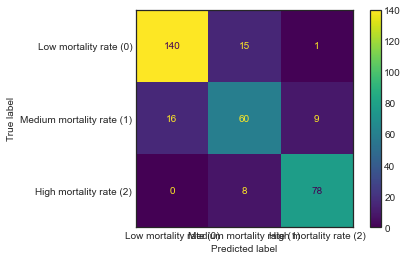

In [49]:
display_cm_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr,
                                        display_labels=['Low mortality rate (0)','Medium mortality rate (1)', 'High mortality rate (2)'])
display_cm_lr.plot()

Logistic model has significant improved performance as the accuracy is 0.850 which is higher than 0.801 (NB model) and 0.755 (KNN model). How about we try tree models to see if they can improve the result. 

### Decision Tree classifier
Let's try a fourth classifier with the same dataset.

#### Firstly, train with default decisiontreeclassifier model.

In [50]:
# default decision tree model
from sklearn.tree import DecisionTreeClassifier 
dtc = DecisionTreeClassifier(random_state=0)
clf = dtc.fit(X_train_2, y_train_2)
y_pred_tree = clf.predict(X_test_2)

print(classification_report(y_test_2, y_pred_tree, digits=3))

              precision    recall  f1-score   support

           0      0.974     0.949     0.961       156
           1      0.885     0.906     0.895        85
           2      0.943     0.965     0.954        86

    accuracy                          0.942       327
   macro avg      0.934     0.940     0.937       327
weighted avg      0.943     0.942     0.942       327



In [51]:
# Use gridsearch cv to tune the default decision tree model by finding best parameters. 
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
params_dtc = { 'min_samples_leaf': range(1,5) ,'max_leaf_nodes': range(20, 40), 'max_depth': range(1,10)}
gs_dtc = GridSearchCV(dtc, param_grid=params_dtc)
gs_dtc.fit(X_train_2, y_train_2)
gs_dtc.best_params_


{'max_depth': 9, 'max_leaf_nodes': 34, 'min_samples_leaf': 1}

In [52]:
# Apply bestparamets to the model 
dtc2 = DecisionTreeClassifier (max_depth = 9, max_leaf_nodes = 34, min_samples_leaf =1, random_state=0)
dtc2.fit(X_train_2, y_train_2)
y_pred_dtc2 = dtc2.predict(X_test_2)
print(classification_report(y_test_2, y_pred_dtc2, digits=3))

              precision    recall  f1-score   support

           0      0.967     0.929     0.948       156
           1      0.835     0.894     0.864        85
           2      0.953     0.953     0.953        86

    accuracy                          0.927       327
   macro avg      0.918     0.926     0.922       327
weighted avg      0.929     0.927     0.927       327



Default decision tree has better accuracy (0.942) than the tuned decision tree. After we tuned the default model with some limitations on parameters, the accuracy decreases to 0.927.

#### Secondly, train with default randomforestclassifier model.

In [53]:
# default random forest model
rfc_default = RandomForestClassifier(random_state=0)
rfc_fit = rfc_default.fit(X_train_2, y_train_2)
y_pred_rfc_default = rfc_fit.predict(X_test_2)

print(classification_report(y_test_2, y_pred_rfc_default, digits=3))

              precision    recall  f1-score   support

           0      0.994     0.987     0.990       156
           1      0.943     0.976     0.960        85
           2      0.988     0.965     0.976        86

    accuracy                          0.979       327
   macro avg      0.975     0.976     0.975       327
weighted avg      0.979     0.979     0.979       327



In [54]:
#find best tree number for random forest to tune the default model 

CV = []
for trees in range(20,501,25):
    rfc = RandomForestClassifier(n_estimators = trees, random_state=0)
    rfc.fit(X_train_2, y_train_2)
    CV_error = np.mean(cross_val_score(rfc, X_train_2, y_train_2, cv=10, scoring = "neg_mean_squared_error"))
    CV.append(CV_error)  
    
CV_scores =np.abs(CV)
min_CV= np.min(CV_scores)
#Number of trees 
best_CV = (np.where(CV_scores == min_CV)[0])*25+20
print('Best number of tree is: ', best_CV)
print("And its corresponding CV score is: ", min_CV)


Best number of tree is:  [295]
And its corresponding CV score is:  0.037492660011743985


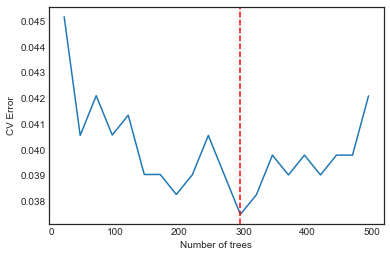

In [55]:
#Create a list for x axis
tree_num = list(range(20,501, 25))
#Plot the graph 
plt.plot(tree_num, CV_scores)
plt.xlabel("Number of trees")
plt.ylabel("CV Error")
plt.axvline(x=best_CV,linestyle='--',color="red")
plt.show()

In [56]:
# Now we know the best tree number is 295, then we can choose the other parameters.
params = {'n_estimators': [295,501], 'max_leaf_nodes':range(20, 40), 'max_depth':range(1,10)}
rfc = RandomForestClassifier(random_state=0)
gs = GridSearchCV(rfc, param_grid=params)
gs.fit(X_train_2, y_train_2)
gs.best_params_

KeyboardInterrupt: 

In [57]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, BaggingRegressor 
# Apply best 3 parameters to the randomforestclassifier model.
rfc2 = RandomForestClassifier (n_estimators = 295, max_depth = 9, max_leaf_nodes = 39,random_state=0)
rfc2.fit(X_train_2, y_train_2)
y_pred_rfc2 = rfc2.predict(X_test_2)
print(classification_report(y_test_2, y_pred_rfc2, digits=3))

              precision    recall  f1-score   support

           0      1.000     0.987     0.994       156
           1      0.912     0.976     0.943        85
           2      0.976     0.930     0.952        86

    accuracy                          0.969       327
   macro avg      0.963     0.965     0.963       327
weighted avg      0.971     0.969     0.970       327



The default random forest model has accuracy of 0.979, and after using GridSearchCV to tune the default model, the accuracy increases to 0.969. So we just pick the default random forest model.

### Now we have to compare auc of knn, nb, lr, decision tree and randrom forest model to find best classifier. 

In [58]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

#find probabilities for all Classifier
knn_probs = knn.predict_proba(X_test_2)
nb_probs = nb.predict_proba(X_test_2)
lr_probs = lr.predict_proba(X_test_2)
dtc_probs = dtc.predict_proba(X_test_2)
rfc_default_probs = rfc_default.predict_proba(X_test_2)

In [59]:
# Calculate the FPR, FPR and TPR according to each threshold for all models. 
auc_knn = roc_auc_score(y_test_2, knn_probs, multi_class='ovr')
print("The AUC for knn is :", auc_knn)

auc_nb = roc_auc_score(y_test_2, nb_probs, multi_class='ovr')
print("The AUC for nb is :", auc_nb)

auc_lr = roc_auc_score(y_test_2, lr_probs, multi_class='ovr')
print("The AUC for lr is :", auc_lr)

auc_dtc = roc_auc_score(y_test_2, dtc_probs, multi_class='ovr')
print("The AUC for decision tree is :", auc_dtc)

auc_rfc2 = roc_auc_score(y_test_2, rfc_default_probs, multi_class='ovr')
print("The AUC for random forest is :", auc_rfc2)

The AUC for knn is : 0.8948588543975595
The AUC for nb is : 0.934080217354237
The AUC for lr is : 0.9550573659215064
The AUC for decision tree is : 0.9557092609745005
The AUC for random forest is : 0.9987021464501141


### Because random forest has the highest AUC, it is our best classifer. Then, we will use it to find feature importance. 

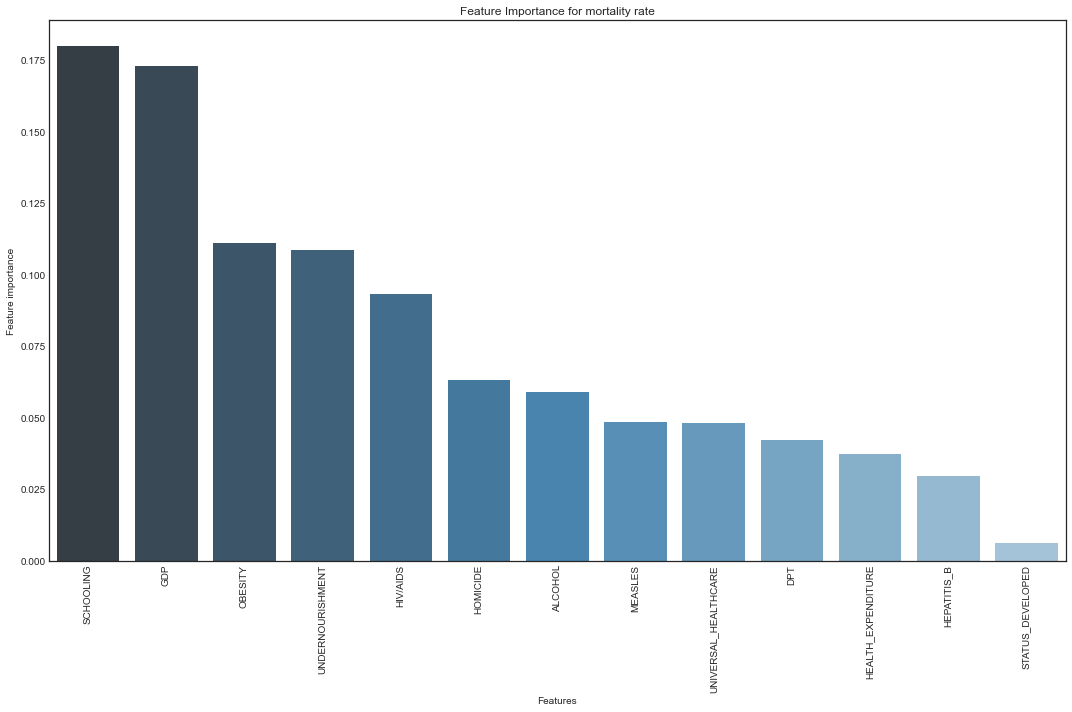

In [60]:

forest_importances = pd.DataFrame({ 'features': list(X_2), 'importances': rfc_default.feature_importances_ })
fig = plt.figure(figsize=(15,10))
#forest_importances
sns.barplot(x="features",y="importances" ,data=forest_importances, 
            order=forest_importances.sort_values('importances',ascending = False).features, palette="Blues_d")

plt.xticks(rotation=90)
plt.title("Feature Importance for mortality rate")
plt.ylabel("Feature importance")
plt.xlabel("Features")
fig.tight_layout()

### Now we can answer the second question:
Grouping the countries into countries with higher mortality rate (>=2.5), countries with medium mortality rate (between 1.0 and 2.5) and countries with lower mortality rate (<1.0), what factors are most important in leading a country with a lower mortality rate? Does increasing healthcare expenditure and having universal health coverage significantly help a country to improve its mortality rate?

1. GDP and schooling are the most important features and undernourishment and obesity rate also play an important role. 

2. Since the healthcare expenditure is eleventh important feature and universal health coverage is nineth, increasing funding for them may not significant decrease mortality rate. So if a government wants to improve mortality rate, they can try to increase funding in schooling. 

## Clustering

3.	Using unsupervised learning to cluster the countries, how will the countries be clustered together? How well are they clustered? What factors do they have in common? Is there a same country in different years clustered to different groups? If so, what might be the reasons behind?

### Correlation Graph

In [61]:
# New Dataset
LE_raw = pd.read_csv("final_data.csv") 
LE = pd.read_csv("final_data.csv") 
LE = LE.dropna()
LE = LE.drop(columns = ["Country", "Code", "Year", "Unnamed: 0"])
LE = pd.get_dummies(LE, columns = ["Status"], drop_first=True)


### Normalize the data

Firstly, here we need to normalize the data for our clusters to get better clustering results

In [62]:
# Normalization
from sklearn import preprocessing
LE_normalized = preprocessing.normalize(LE)

### K-Means

To determine the best number of K, use KElbowVisualizer and Calinski Harabasz Score

In [63]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, InterclusterDistance, SilhouetteVisualizer


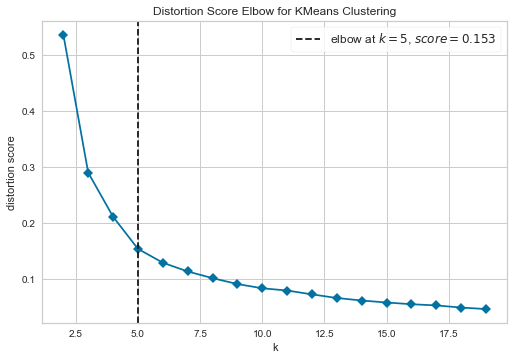

In [64]:
# Create a Kmeans model
model = KMeans(random_state=1)


# Run from k=2 to k=20
visualizer = KElbowVisualizer(model, k=(2,20), timings = False, size=(600, 400))
visualizer.fit(LE_normalized)
visualizer.show()

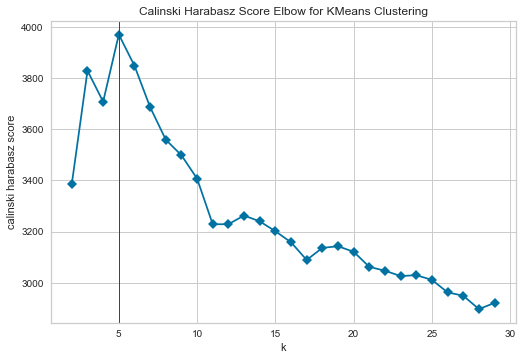

In [65]:
# Calculate the optimal k with Calinski Harabazs
visualizer = KElbowVisualizer(model, k=(2,30), metric='calinski_harabasz', locate_elbow=False, timings=False, size=(600, 400))
visualizer.fit(LE_normalized)
plt.axvline(5, linewidth=1, color='r') # Draw a vertical line of 5 to help us see if 17 is the optimal value or 18.
visualizer.show();

In [66]:
# Fit the model to the chosen k = 5
model_tuned1 = KMeans(5, random_state=1).fit(LE_normalized)

#### Examination for the chosen K

To examine the chosen K, use the Solhouette Plot and Intercluster Distance Map

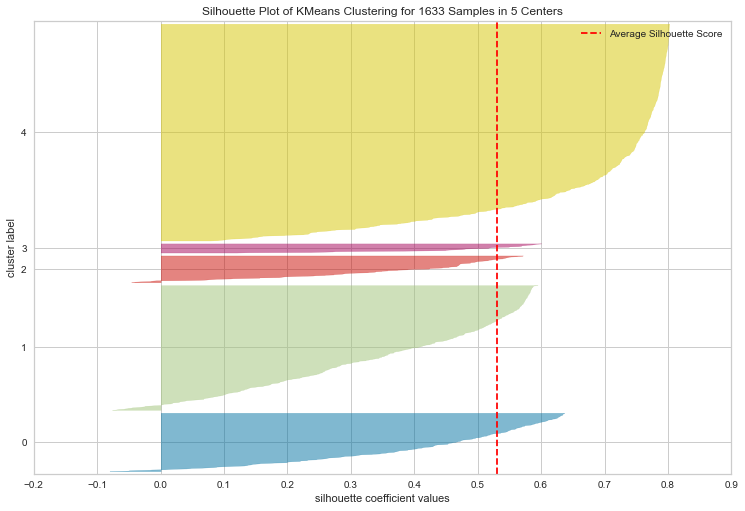

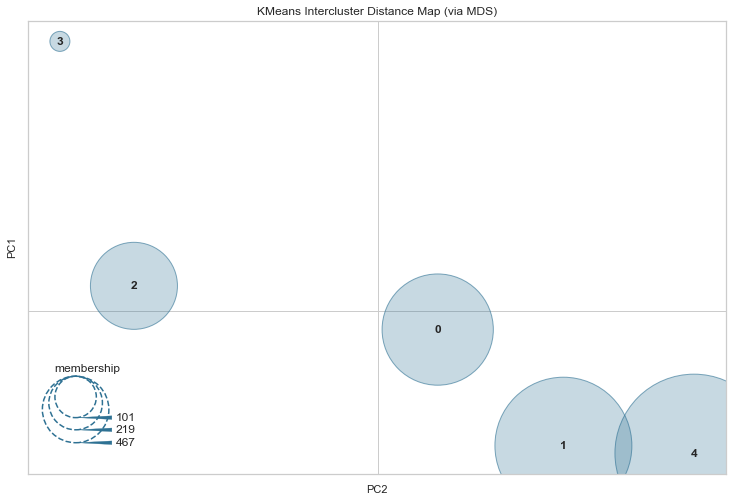

In [67]:
#  Examination for the chosen K - Sillhouette plot
visualizer_1 = SilhouetteVisualizer(model_tuned1, colors='yellowbrick', size=(900, 600))
visualizer_1.fit(LE_normalized) 
visualizer_1.show()

#  Examination for the chosen K - InterclusterDistance plot
visualizer_2 = InterclusterDistance(model_tuned1, size=(900, 600), random_state=0)
visualizer_2.fit(LE_normalized) 
visualizer_2.show()


The K-means model with K = 5 seems to work fine. Only very few values are below 0, and the Average Silhouette Score is above 0.5.

Also, from the Intercluster Distance Map, we see that there's only very little overlapping between the clusters.

So, K-means model with K = 5 seems to work well.

#### A graph for K-Means

To make sure this model works well, we can draw some plots to see how the data points are spread and clustered.

Here we choose the 'GDP' and 'Health expenditure' as y and x of the plot because in the correlation heatmap at the begginning, these two features only have -0.2 correlation, meaning that they are not correlated closely. This will help us to see how the countries are clustered in the graph.

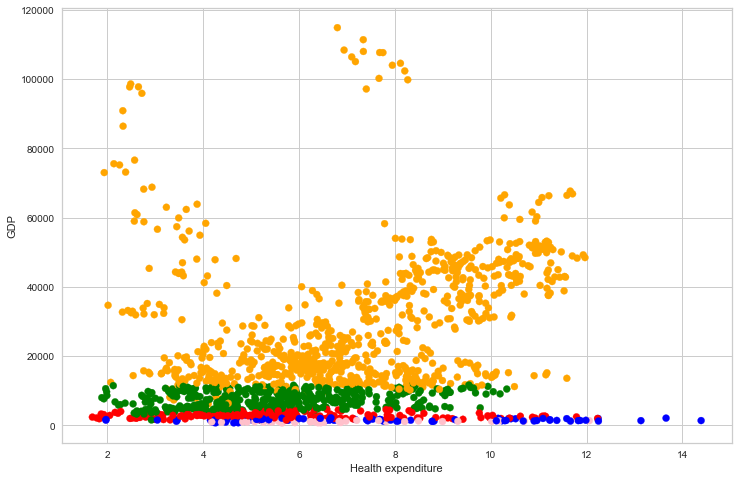

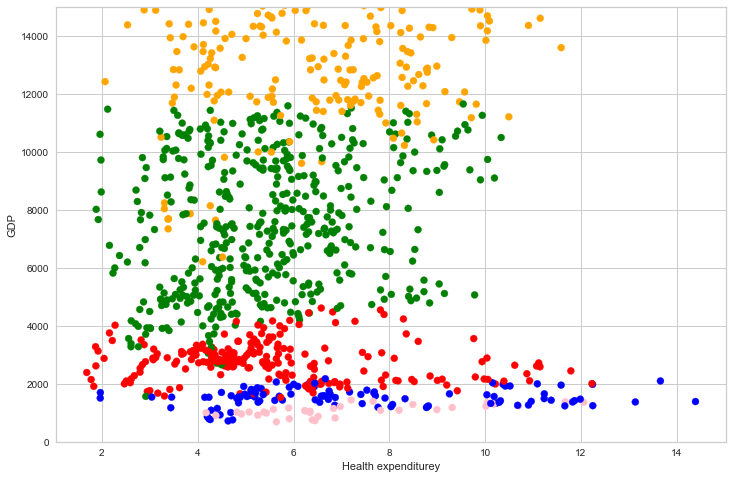

In [68]:
# Colors for the clusters
colors = np.array(["red","green","blue","pink","orange","magenta","purple","cyan"])

# Draw the GDP ~ Health Expenditure scatterplot
plt.figure(figsize=(12, 8))
plt.scatter(LE['Health expenditure'], LE['GDP'], c=colors[model_tuned1.labels_])
plt.xlabel('Health expenditure')
plt.ylabel('GDP')
plt.show()

# From the bottom part of the first graph, we can not see some points clearly, so we reduce the range of y to have a clearer view of that part
plt.figure(figsize=(12, 8))
plt.scatter(LE['Health expenditure'], LE['GDP'], c=colors[model_tuned1.labels_])
plt.ylim((0., 15000))
plt.xlabel('Health expenditurey')
plt.ylabel('GDP')
plt.show()

From the graphs above, even though we already normalized the data for clustering. It seems that GDP still plays a very important role in clustering the countries. It's like the main boundary for these clusters.

Maybe this is because GDP will affect many other variables like 'Life expectancy' and 'Mortality Rate', so it will be more important.

### Hierarchical Clustering

Here for Hierarchical Clustering, we'll still cluster the data into 5 groups to compare it with the K-means clustering.

In [69]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import make_blobs
import scipy.cluster.hierarchy as shc


hc_avg = AgglomerativeClustering(n_clusters=5, linkage='average')
hc_avg.fit_predict(LE_normalized)


array([2, 2, 2, ..., 2, 2, 2], dtype=int64)

#### Graphs for Hierarchical Clustering with Linkage in 'Average', 'Single', 'Complete'

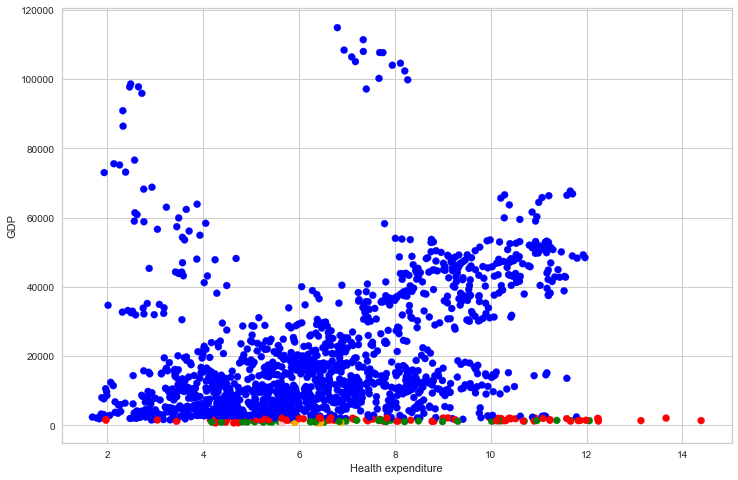

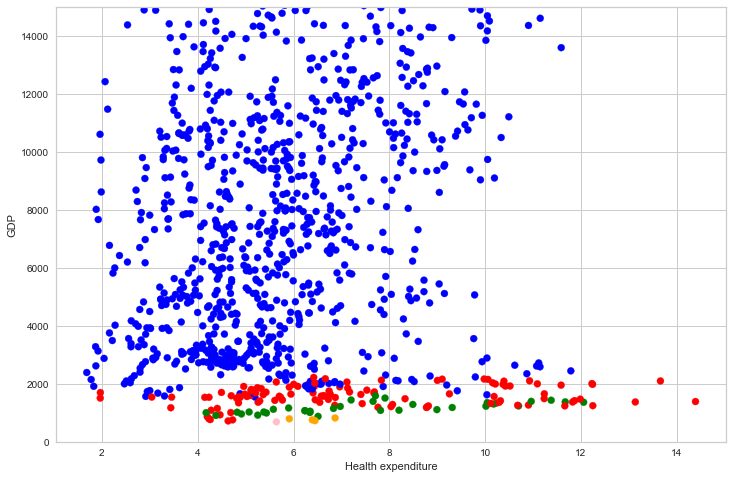

In [70]:
plt.figure(figsize=(12, 8))
plt.scatter(LE['Health expenditure'], LE['GDP'], c=colors[hc_avg.labels_])
plt.xlabel('Health expenditure')
plt.ylabel('GDP')
plt.show()

plt.figure(figsize=(12, 8))
plt.scatter(LE['Health expenditure'], LE['GDP'], c=colors[hc_avg.labels_])
plt.ylim((0., 15000))
plt.xlabel('Health expenditure')
plt.ylabel('GDP')
plt.show()

It's very similar to the clustering result of K-means, but more countries are classified into the group that have relatively higher GDP (Blue points).

In [71]:
# Extract the data by the clusters
# Reference: https://stackoverflow.com/questions/36195457/how-to-get-the-samples-in-each-cluster
cluster_map = pd.DataFrame()
cluster_map['data_index'] = LE.index.values
cluster_map['cluster'] = model_tuned1.labels_

LE['Cluster'] = model_tuned1.labels_

In [72]:
# Set the Linkage to 'single'
hc_sing = AgglomerativeClustering(n_clusters=5, linkage='single')
hc_sing.fit_predict(LE_normalized)


array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

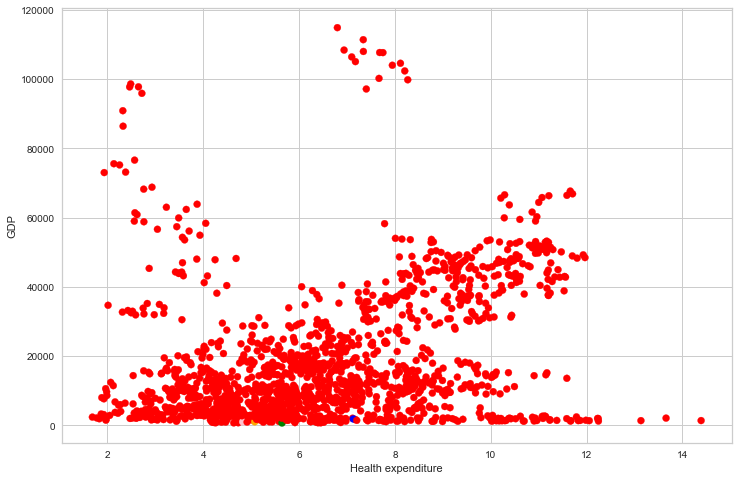

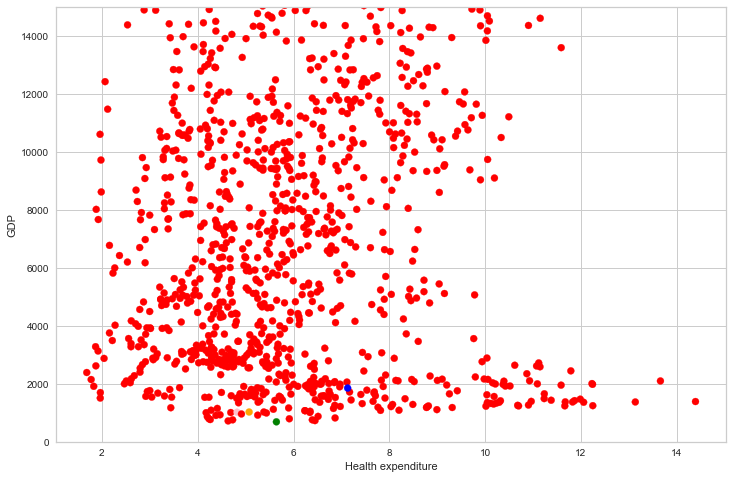

In [73]:
plt.figure(figsize=(12, 8))
plt.scatter(LE['Health expenditure'], LE['GDP'], c=colors[hc_sing.labels_])
plt.xlabel('Health expenditure')
plt.ylabel('GDP')
plt.show()

plt.figure(figsize=(12, 8))
plt.scatter(LE['Health expenditure'], LE['GDP'], c=colors[hc_sing.labels_])
plt.ylim((0., 15000))
plt.xlabel('Health expenditure')
plt.ylabel('GDP')
plt.show()

It seems that 'single' is not a good option for linkage because nearly all data points are clustered together.

In [74]:
# Set the Linkage to 'complete'
hc_com = AgglomerativeClustering(n_clusters=5, linkage='complete')
hc_com.fit_predict(LE_normalized)

array([3, 3, 3, ..., 1, 1, 1], dtype=int64)

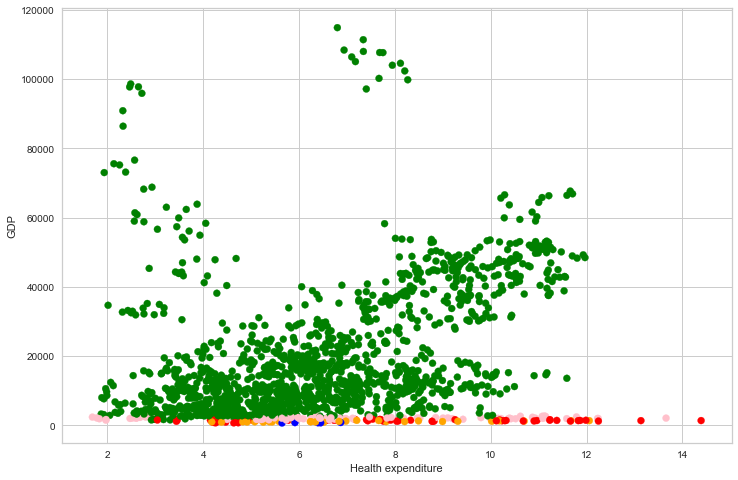

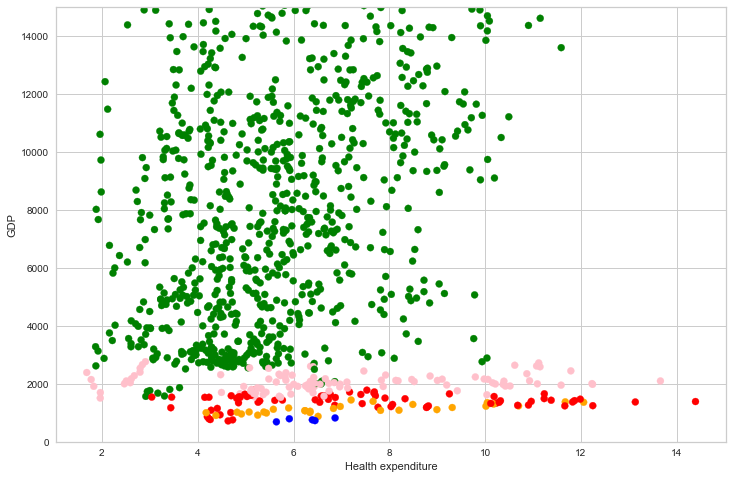

In [75]:
plt.figure(figsize=(12, 8))
plt.scatter(LE['Health expenditure'], LE['GDP'], c=colors[hc_com.labels_])
plt.xlabel('Health expenditure')
plt.ylabel('GDP')
plt.show()

plt.figure(figsize=(12, 8))
plt.scatter(LE['Health expenditure'], LE['GDP'], c=colors[hc_com.labels_])
plt.ylim((0., 15000))
plt.xlabel('Health expenditure')
plt.ylabel('GDP')
plt.show()

It seems that in this case, 'complete' as a linkage option is quite similar to 'average'.

### Comparing the results

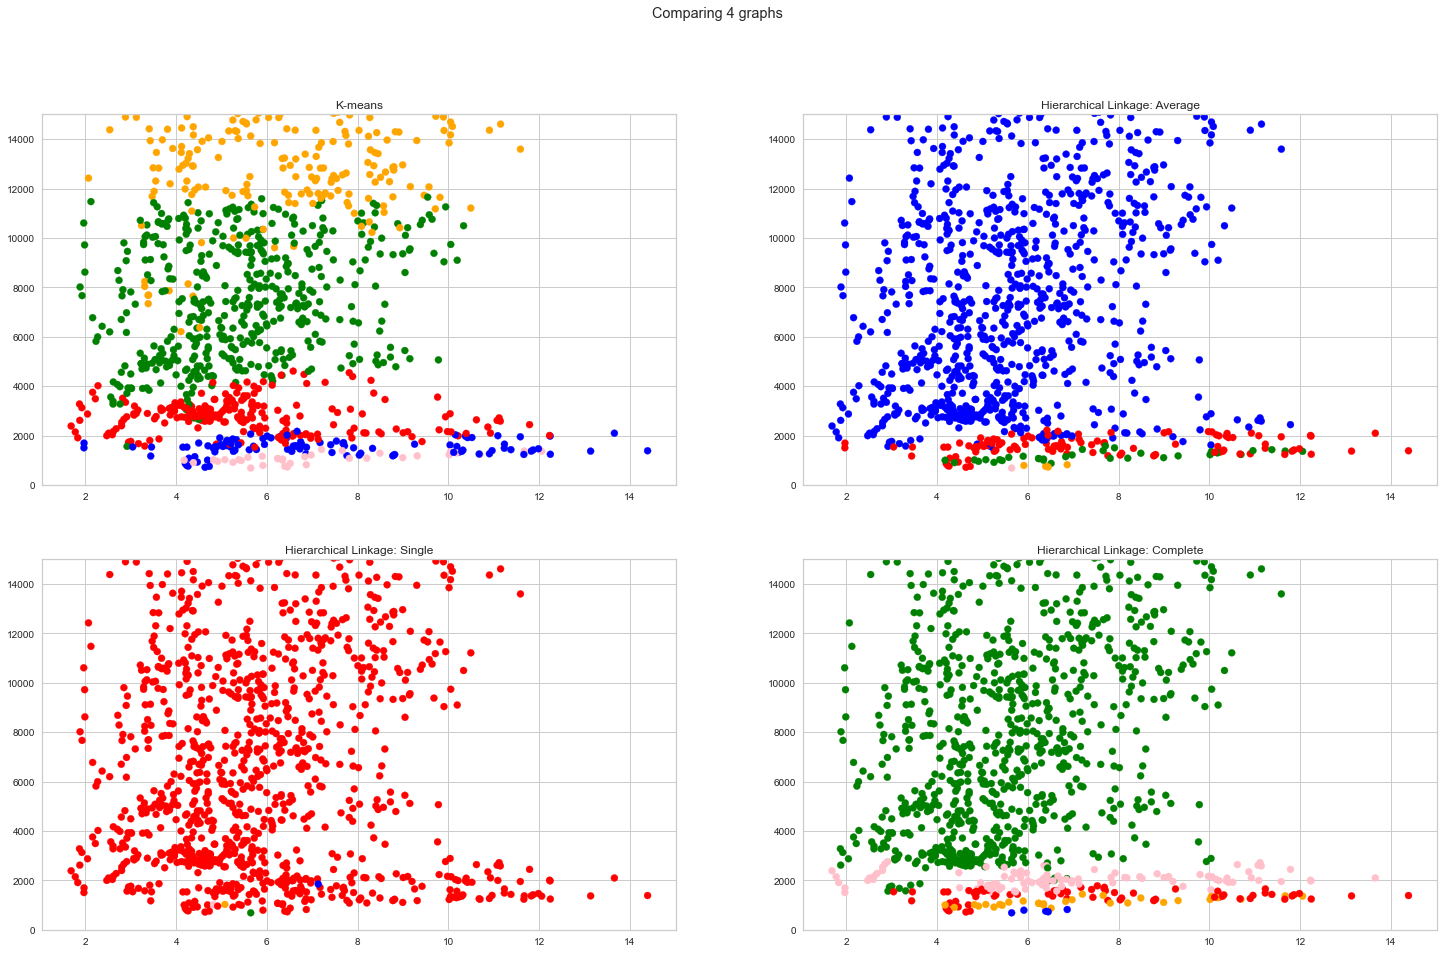

In [76]:
# Plot the graphs before in one graph to compare their difference
plt.suptitle('Comparing 4 graphs')

plt.subplot(2, 2, 1)
plt.title('K-means')
plt.ylim((0., 15000))
plt.scatter(LE['Health expenditure'], LE['GDP'], c=colors[model_tuned1.labels_])

plt.subplot(2, 2, 2)
plt.title('Hierarchical Linkage: Average')
plt.ylim((0., 15000))
plt.scatter(LE['Health expenditure'], LE['GDP'], c=colors[hc_avg.labels_])

plt.subplot(2, 2, 3)
plt.title('Hierarchical Linkage: Single')
plt.ylim((0., 15000))
plt.scatter(LE['Health expenditure'], LE['GDP'], c=colors[hc_sing.labels_])

plt.subplot(2, 2, 4)
plt.title('Hierarchical Linkage: Complete')
plt.ylim((0., 15000))
plt.scatter(LE['Health expenditure'], LE['GDP'], c=colors[hc_com.labels_])

fig = plt.gcf()
fig.set_size_inches(25, 15)

Comparing the graphs for K-means and Hierarchical graphs, it seems that K-means with K = 5 is still a good choice in clustering because there is no problem with chaining or crowding, and it's still looks better than Hierarchical in linkage of 'Average'.

However, because this is unsupervised learning, we can not decide which is the 'best' model since we can not validate the models. So, we just pick one that is easier to observe to answer our question.

Therefore, in later work, we'll keep using the K-means results to observe the clusters.

### Now, we can draw some boxplots to observe the differences of clustered groups.

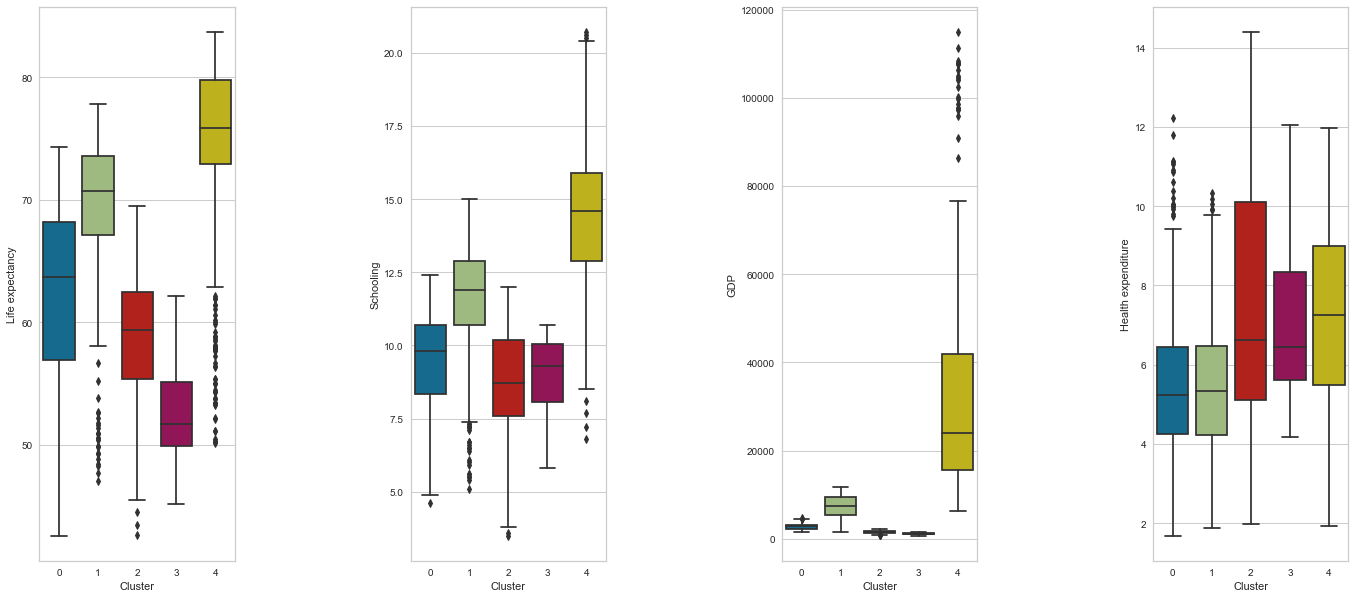

In [77]:
# Draw some plots to see some more information about the difference between these clusters
fig, axes = plt.subplots(1,4)
fig.tight_layout(pad=3.0)
fig.set_size_inches(22, 10)
sns.boxplot(y = 'Life expectancy', x = 'Cluster', data=LE, ax=axes[0]) # For weekdays
sns.boxplot(y = 'Schooling', x = 'Cluster', data=LE, ax=axes[1]) # For weekends
sns.boxplot(y = 'GDP', x = 'Cluster', data=LE, ax=axes[2])
sns.boxplot(y = 'Health expenditure', x = 'Cluster', data=LE, ax=axes[3])
plt.show()

From boxplot 1 and 2, the life expectancy and schooling for the clusters are quite different. They may be important in clustering the countries.

From boxplot 3, the 4th cluster has significantly higher average GDP than all other clusters, and among cluster 0 to 3, cluster 1 also seem to have higher GDP than other clusters. This is in line with the guess before: GDP somehow plays an important role in clustering the countries.

From boxplot 4, the difference seems to be not that big between the groups, so it may be not that important in clustering the countries.

#### Extract the countries that are clustered into different groups

Because our dataset contains cross-year data for countries, a country in a certain year is considered a separate data point, Thus, a country in different years may be clustered into different clusters.

In [78]:
# Get the country names of each cluster
country_names_cluster = []
for i in range(0, 5):
    cluster_i = LE_raw.loc[cluster_map[cluster_map['cluster'] == i]['data_index']]
    country_names_cluster.append(list(set(list(cluster_i['Country']))))

# Print the country names of each cluster
for n in range(0, 5):
    print('Cluster', n)
    print(country_names_cluster[n])

# Convert the list of clusters into a whole list (including duplicates to calculate the occurrence)
country_names_cluster_flat = [item for sublist in country_names_cluster for item in sublist]

# Print the countries that have occurrence greater than 1
print('\nCountries that appears more than once in these clusters:')
for item in set(country_names_cluster_flat): # Used 'set' here to count the unique countries
    if country_names_cluster_flat.count(item) > 1:
        print(item, country_names_cluster_flat.count(item))
    if country_names_cluster_flat.count(item) > 2:
        print(item, country_names_cluster_flat.count(item), '(This country(s) appears more than twice)')
   

Cluster 0
['Mali', 'Bangladesh', 'Nepal', 'Ethiopia', 'Sao Tome and Principe', 'Kenya', 'Kiribati', 'Senegal', 'Haiti', 'Ghana', 'Honduras', 'Cameroon', 'Solomon Islands', 'Vietnam', 'Uzbekistan', 'Myanmar', 'Afghanistan', 'Nicaragua', 'Liberia', 'Togo', 'Vanuatu', 'Lesotho', 'Benin', 'Chad', 'China', 'Cambodia', 'Madagascar']
Cluster 1
['Philippines', 'Ecuador', 'Nigeria', 'Angola', 'Azerbaijan', 'Albania', 'Serbia', 'Tunisia', 'India', 'Pakistan', 'Dominican Republic', 'Algeria', 'Peru', 'Turkmenistan', 'Morocco', 'Samoa', 'Sri Lanka', 'Bulgaria', 'Ghana', 'El Salvador', 'Iraq', 'Armenia', 'Guatemala', 'Guyana', 'Honduras', 'Vietnam', 'Bosnia and Herzegovina', 'Uzbekistan', 'Jordan', 'Nicaragua', 'Mauritania', 'Paraguay', 'Ukraine', 'Namibia', 'Belize', 'Georgia', 'Indonesia', 'Belarus', 'Jamaica', 'Thailand', 'Chad', 'Fiji', 'China', 'Mongolia', 'Colombia', 'Bolivia']
Cluster 2
['Kiribati', 'Malawi', 'Solomon Islands', 'Lesotho', 'Ethiopia', 'Burkina Faso', 'Liberia', 'Sierra Leone'

From the results above, we can see that 'China' appears three times, meaning that it has been clustered into three clusters. This indicates that China had experienced some more big changes in the features of this dataset than other countries in these years.

So, in the next part, we can take a look at some 'cross-year' features of China to have a general view of how big these changes are.

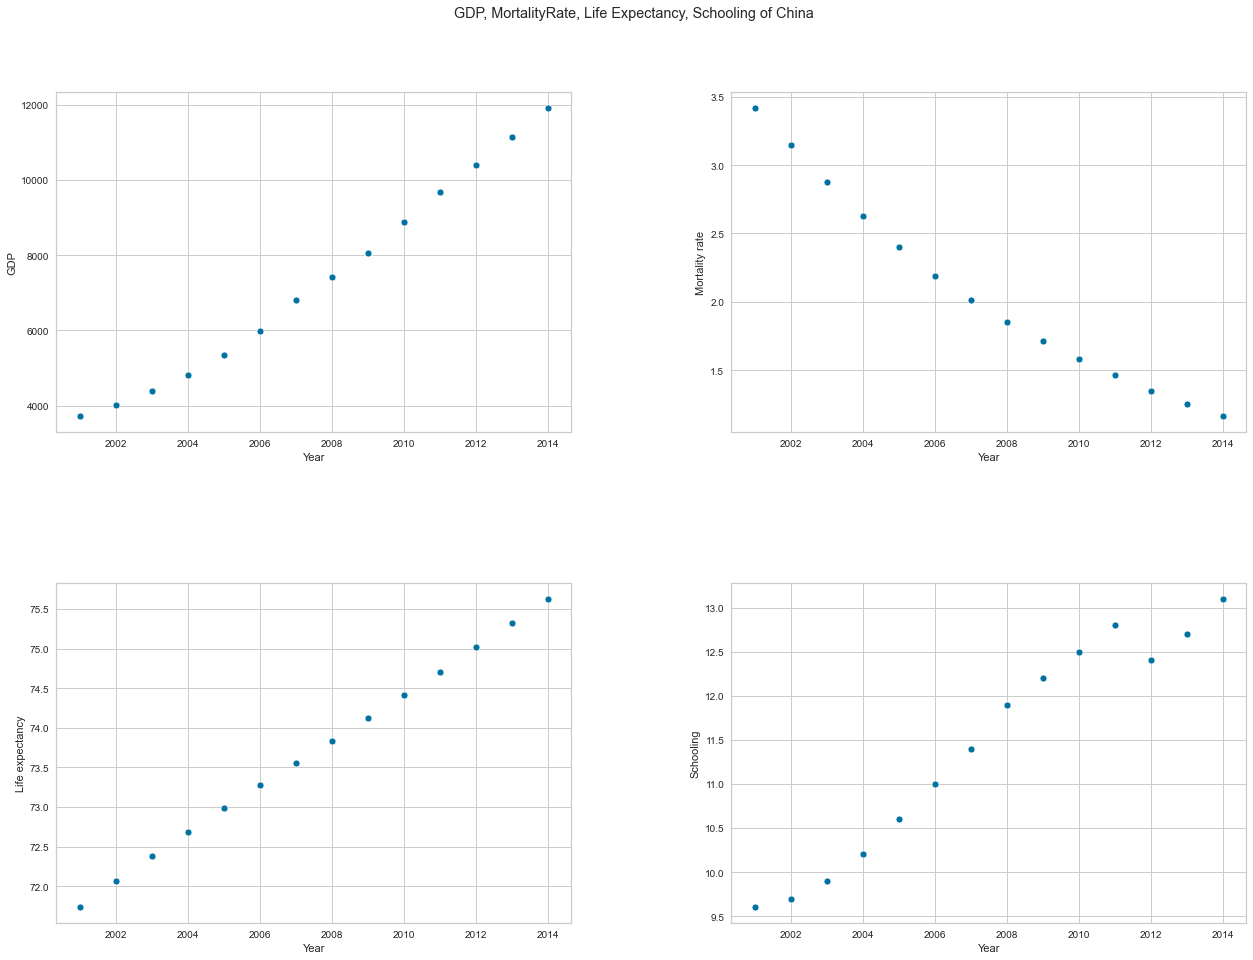

In [79]:
# Extract the data for China
data_china = LE_raw[LE_raw['Country']=='China']

fig, axes = plt.subplots(2,2)
fig.tight_layout(pad=3.0)
fig.set_size_inches(20, 15)
plt.suptitle('GDP, MortalityRate, Life Expectancy, Schooling of China')
sns.scatterplot(data_china['Year'], data_china['GDP'] , ax=axes[0,0]) 
sns.scatterplot(data_china['Year'], data_china['Mortality rate'] , ax=axes[0,1])
sns.scatterplot(data_china['Year'], data_china['Life expectancy'] , ax=axes[1, 0])
sns.scatterplot(data_china['Year'], data_china['Schooling'] , ax=axes[1, 1])

From the graphs above we can see that these important features of China kept improving in those years. Especially GDP, it changes from below 4000 at the beginning to about 12000. 

Maybe this is why it transfered from clusters to clusters. This is in line with out guess before: GDP plays an important role in the cluster of these countries.

### Now we can answer the third question:
Using unsupervised learning to cluster the countries, how will the countries be clustered together? How are they clustered? What factors do they have in common? Is there a same country in different years clustered to different groups? If so, what might be the reasons behind? 

1. The countries are clustered well according to the Silhouette plot and InterCluster Distance Plot.

2. It seems that GDP plays a very important role in clustering the countries. Many countries with high GDP are clustered together, and some countries with very low GDP are clustered together.

3. Because GDP may play a very important role, countries that have high GDP growth such as China may switch from a cluster to another. However, those countries with high GDP decrease may also have some switches. 

### References

Answer for Data Mining: Homework 1, Homework 2, Lab 1, Lab 2
### Coding references

https://www.icode9.com/content-1-426849.html

https://stackoverflow.com/questions/46334525/how-to-copy-multiple-input-cells-in-jupyter-notebook

https://stackoverflow.com/questions/56710506/pca-recover-most-important-features-in-a-dataframe

https://www.codetd.com/article/5247437

https://stats.stackexchange.com/questions/46576/how-to-find-genes-associated-with-pc1-and-pc2-after-the-pca-on-microarray

https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.subplots.html

https://stackoverflow.com/questions/15161657/iteration-over-variable-names-in-python

https://stackoverflow.com/questions/36195457/how-to-get-the-samples-in-each-cluster

### Datasets link

Life Expectancy:
https://ourworldindata.org/life-expectancy

Obesity:
https://ourworldindata.org/obesity

Alcohol Consumption:
https://ourworldindata.org/alcohol-consumption

Homicides:
https://ourworldindata.org/homicides

Healthcare Expenditure as Share of National GDP By country
https://ourworldindata.org/grapher/total-healthcare-expenditure-as-share-of-national-gdp-by-country?tab=table

Undernourishment:
https://ourworldindata.org/hunger-and-undernourishment

GDP Per Capita:
https://ourworldindata.org/grapher/gdp-per-capita-worldbank

Child Mortality:
https://ourworldindata.org/child-mortality

Health Protection Coverage:
https://ourworldindata.org/grapher/health-protection-coverage

Hep B
https://data.worldbank.org/indicator/SH.IMM.HEPB

DPT
https://data.worldbank.org/indicator/SH.IMM.IDPT

Measles
https://data.worldbank.org/indicator/SH.IMM.MEAS

